In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-and-images-socal/socal2.csv
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/7981.jpg
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/12666.jpg
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/13288.jpg
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/6234.jpg
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/1269.jpg
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/3863.jpg
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/6241.jpg
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/10304.jpg
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/623.jpg
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/2193.jpg
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/14143.jpg
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/11925.jpg
/kaggle/input/house-prices-and-images-socal/socal2/socal_pics/3750.jpg
/kaggle/input/hous

# 1. Importing important libraires

In [25]:
import numpy as np
import pandas as pd
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Activation, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

# 2. loading data set

In [26]:
data = pd.read_csv("/kaggle/input/house-prices-and-images-socal/socal2.csv")

# 3. Understanding data

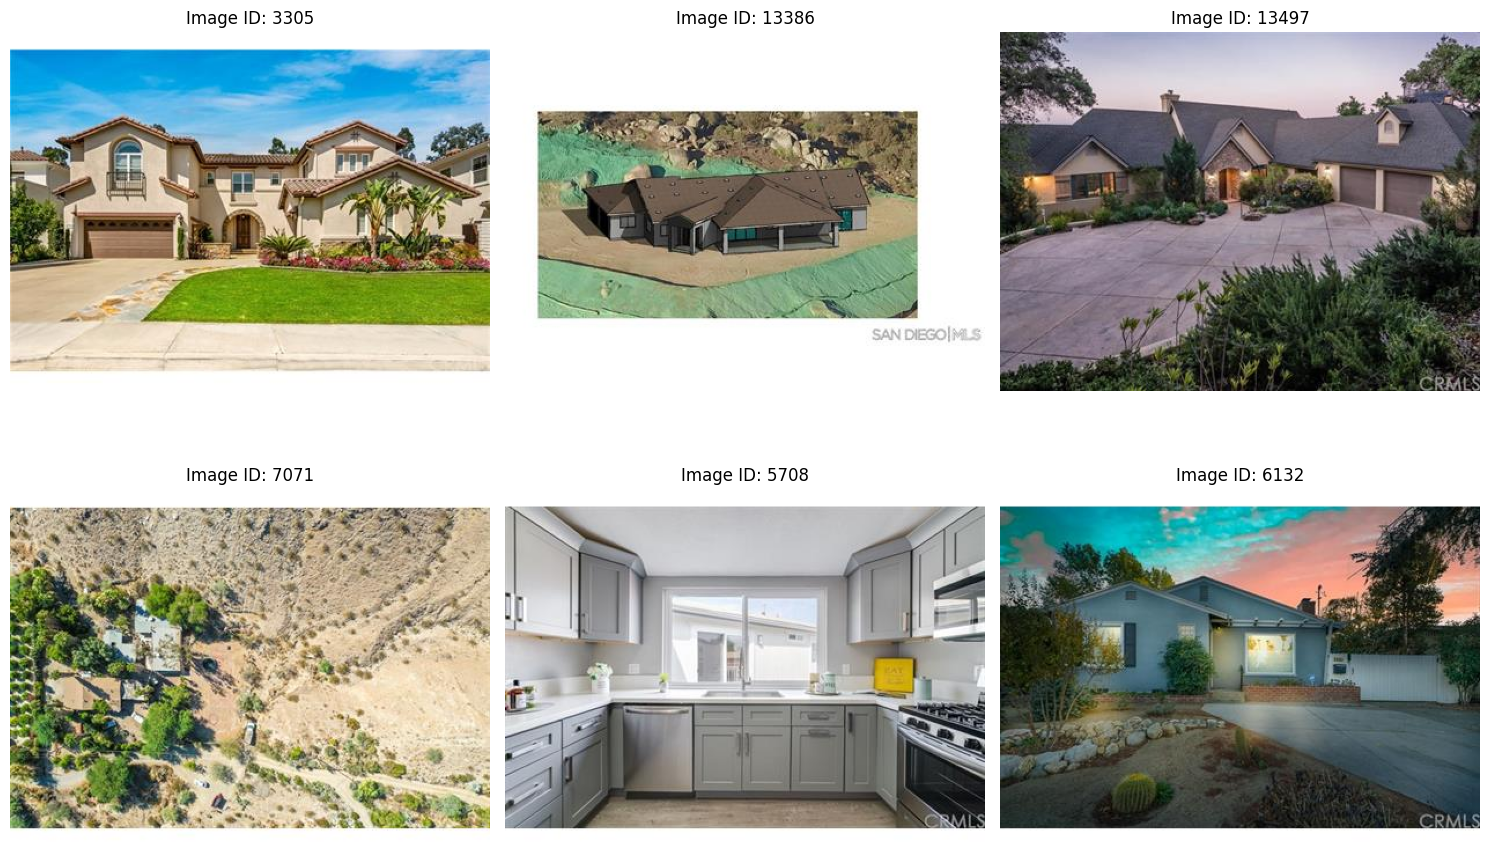

In [27]:
def display_random_images(image_folder, df, num_images=6):
    # Randomly select 'num_images' image IDs from the dataframe
    image_ids = random.sample(list(df['image_id']), min(num_images, len(df)))

    # Display the images
    plt.figure(figsize=(15, 10))
    for i, image_id in enumerate(image_ids):
        img_filename = f"{image_id}.jpg"  # Assuming image filenames are like 'image_id.jpg'
        img_path = os.path.join(image_folder, img_filename)

        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.subplot(2, 3, i+1)  # Change subplot dimensions according to your preference
            plt.imshow(img)
            plt.title(f"Image ID: {image_id}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Replace 'image_folder_path' with the path to your image folder
image_folder_path = '/kaggle/input/house-prices-and-images-socal/socal2/socal_pics'

# Assuming your DataFrame is named 'your_dataset_df'
# Call the function to display 6 random images
display_random_images(image_folder_path, data)

In [28]:
def get_unique_image_sizes(image_folder, df):
    # Initialize an empty set to store unique image sizes
    unique_image_sizes = set()

    # Iterate through each image_id in the DataFrame
    for image_id in df['image_id']:
        # Create the image filename based on image_id
        img_filename = f"{image_id}.jpg"
        # Construct the full image path by joining folder path and image filename
        img_path = os.path.join(image_folder, img_filename)

        # Check if the image file exists
        if os.path.exists(img_path):
            # Open the image using PIL library
            with Image.open(img_path) as img:
                # Get the width and height of the image
                width, height = img.size
                size = (width, height)
                # Add the image size as a tuple to the set of unique image sizes
                unique_image_sizes.add(size)

    # Return the set containing unique image sizes
    return unique_image_sizes

# Get unique image sizes by calling the function
unique_sizes = get_unique_image_sizes(image_folder_path, data)

# Print all unique image sizes retrieved
print("Unique Image Sizes in all data:")
for size in unique_sizes:
    print(size)

Unique Image Sizes in all data:
(350, 350)
(525, 350)
(415, 311)


# 4. Preprocessing 

In [29]:
# Initialize variables
cnt = 0  #This Counter to keep track of the number of images processed
# Create an empty numpy array to store images with shape (15474, 64, 64, 3) and data type 'uint32'
X_house_images = np.zeros((15474, 64, 64, 3), dtype='uint32')

# Loop through a range of image indices (assuming they start from 0 and go up to 15473)
for i in range(15474):
    # Read an image using OpenCV based on its filename and path
    sample = cv2.imread(image_folder_path + '/' + str(i) + '.jpg')
    # Resize the image to dimensions 64x64
    imgs = cv2.resize(sample, (64, 64))
    # Assign the resized image to the array of images at the current index 'cnt'
    X_house_images[cnt] = imgs
    # Increment the counter
    cnt += 1

# Display the total number of images processed
print("No. of images: ", cnt)

No. of images:  15474


In [30]:
# Normalize pixel values in image data by scaling them between 0 and 1
X_house_images = X_house_images/255.0

In [31]:
def preprocess_images_with_cv2_and_ids(image_folder, target_size=(64, 64)):
    resized_images = []
    image_ids = []

    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(image_folder, filename)

            img = cv2.imread(img_path)
            resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            # Normalize pixel values by dividing by 255
            resized_img = resized_img / 255.0
            resized_images.append(resized_img)

            # Extract image ID (assuming filename is in the format "image_id.jpg")
            image_id = int(filename.split('.')[0])  # Extract the ID from the filename
            image_ids.append(image_id)

    return resized_images, image_ids

# Call the updated function to preprocess images and retrieve image IDs
preprocessed_images, image_ids = preprocess_images_with_cv2_and_ids(image_folder_path, target_size=(64, 64))

In [18]:
"""def display_random_images_preprocessed(image_folder, df, num_images=6, target_size=(64, 64)):
    # Randomly select 'num_images' image IDs from the dataframe
    image_ids = random.sample(list(df['image_id']), min(num_images, len(df)))

    # Preprocess the images using cv2
    preprocessed_images = preprocess_images_with_cv2(image_folder, target_size=target_size)

    # Display the preprocessed images
    plt.figure(figsize=(15, 10))
    for i, image_id in enumerate(image_ids):
        img = preprocessed_images[i] if i < len(preprocessed_images) else None

        if img is not None:
            plt.subplot(2, 3, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying with Matplotlib
            plt.title(f"Image ID: {image_id}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming your DataFrame is named 'your_dataset_df' and contains 'image_id' column
# Call the function to display 6 random preprocessed images
display_random_images_preprocessed(image_folder_path, X_train)"""

'def display_random_images_preprocessed(image_folder, df, num_images=6, target_size=(64, 64)):\n    # Randomly select \'num_images\' image IDs from the dataframe\n    image_ids = random.sample(list(df[\'image_id\']), min(num_images, len(df)))\n\n    # Preprocess the images using cv2\n    preprocessed_images = preprocess_images_with_cv2(image_folder, target_size=target_size)\n\n    # Display the preprocessed images\n    plt.figure(figsize=(15, 10))\n    for i, image_id in enumerate(image_ids):\n        img = preprocessed_images[i] if i < len(preprocessed_images) else None\n\n        if img is not None:\n            plt.subplot(2, 3, i + 1)\n            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying with Matplotlib\n            plt.title(f"Image ID: {image_id}")\n            plt.axis(\'off\')\n\n    plt.tight_layout()\n    plt.show()\n\n# Assuming your DataFrame is named \'your_dataset_df\' and contains \'image_id\' column\n# Call the function to di

# 4. Modeling

In [32]:
def create_ann(dim, regress=False):
    # Define the Multi-Layer Perceptron (MLP) network
    model = Sequential()  # Create a Sequential model instance

    # Add the input layer and first hidden layer to the model
    model.add(Dense(8, input_dim=dim, activation="relu"))  # Dense layer with 8 neurons and ReLU activation

    # Add another hidden layer to the model
    model.add(Dense(4, activation="relu"))  # Dense layer with 4 neurons and ReLU activation

    # Return the created model
    return model

In [33]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming TensorFlow/channels-last ordering
    inputShape = (height, width, depth)  # Input shape for images (height, width, depth)
    chanDim = -1  # Channel dimension for TensorFlow (channels-last ordering)

    # define the model input
    inputs = Input(shape=inputShape)

    # CNN architecture
    x = Conv2D(16, (3, 3), padding="same")(inputs)  # Convolutional layer with 16 filters and 3x3 kernel
    x = Activation("relu")(x)  # ReLU activation function
    x = BatchNormalization(axis=chanDim)(x)  # Batch normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Max pooling

    x = Conv2D(32, (3, 3), padding="same")(x)  # Another convolutional layer with 32 filters and 3x3 kernel
    x = Activation("relu")(x)  # ReLU activation function
    x = BatchNormalization(axis=chanDim)(x)  # Batch normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Max pooling

    x = Conv2D(64, (3, 3), padding="same")(x)  # Another convolutional layer with 64 filters and 3x3 kernel
    x = Activation("relu")(x)  # ReLU activation function
    x = BatchNormalization(axis=chanDim)(x)  # Batch normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Max pooling

    x = Flatten()(x)  # Flatten the output for fully connected layers
    x = Dense(16)(x)  # Fully connected layer with 16 neurons
    x = Activation("relu")(x)  # ReLU activation function
    x = BatchNormalization(axis=chanDim)(x)  # Batch normalization
    x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting

    x = Dense(4)(x)  # Fully connected layer with 4 neurons
    x = Activation("relu")(x)  # ReLU activation function

    # Construct the CNN model
    model = Model(inputs, x)

    # Return the CNN model
    return model

In [34]:
X_data_tab = data[["n_citi",'bed','bath',"sqft", "price"]]
y_data = data["price"]

In [37]:
# Split data into training and testing sets (tabular + images)
Xatt_train, Xatt_test, Ximage_train, Ximage_test = train_test_split(
    X_data_tab, X_house_images, test_size=0.25, random_state=42
)

# Extract target variable (price) and reshape for regression
y_train, y_test = Xatt_train['price'].values, Xatt_test['price'].values
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Extract tabular features (bed, bath, sqft)
X1_train = Xatt_train[['bed', 'bath', 'sqft']].values
X1_test = Xatt_test[['bed', 'bath', 'sqft']].values

# Image data stays as is
X2_train = Ximage_train
X2_test = Ximage_test

# Print shapes for verification
print(f"X_train shape (tabular): {X1_train.shape}")
print(f"X_train shape (images): {X2_train.shape}\n")

print(f"X_test shape (tabular): {X1_test.shape}")
print(f"X_test shape (images): {X2_test.shape}\n")

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape (tabular): (11605, 3)
X_train shape (images): (11605, 64, 64, 3)

X_test shape (tabular): (3869, 3)
X_test shape (images): (3869, 64, 64, 3)

y_train shape: (11605, 1)
y_test shape: (3869, 1)


**ANN for tabuler data**

In [41]:
def create_ann(input_dim, regress=False):
    # Input for tabular data
    input_layer = Input(shape=(input_dim,))
    x = Dense(64, activation="relu")(input_layer)
    x = Dense(32, activation="relu")(x)
    
    if regress:
        x = Dense(1, activation="linear")(x)
        return Model(inputs=input_layer, outputs=x)
    
    return Model(inputs=input_layer, outputs=x)

**cnn for image data**

In [42]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

def create_cnn(width, height, depth, regress=False):
    # Input for images
    input_layer = Input(shape=(height, width, depth))
    
    x = Conv2D(32, (3,3), activation="relu")(input_layer)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, (3,3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    
    if regress:
        x = Dense(1, activation="linear")(x)
        return Model(inputs=input_layer, outputs=x)
    
    return Model(inputs=input_layer, outputs=x)


In [43]:
from tensorflow.keras.layers import Dense, concatenate
from tensorflow.keras.models import Model

# Create ANN + CNN models
mlp = create_ann(X1_train.shape[1], regress=False)     # ANN for tabular data
cnn = create_cnn(64, 64, 3, regress=False)             # CNN for image data

# Combine ANN and CNN outputs
combinedInput = concatenate([mlp.output, cnn.output])

# Add dense layers on top
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# Final model
model = Model(inputs=[mlp.input, cnn.input], outputs=x)
model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 62, 62,    │        896 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 31, 31,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 29, 29,    │     18,496 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 14, 14,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 12544)     │          0 │ max_pooling2d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │        256 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │    802,880 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │      2,080 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dense_21[0][0],   │
│ (Concatenate)       │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 4)         │        388 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 1)         │          5 │ dense_23[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 825,001 (3.15 MB)

 Trainable params: 825,001 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Define the Multi-Layer Perceptron (MLP) model
mlp_input = Input(shape=(X1_train.shape[1],))  # Input layer for MLP with input shape derived from training data
mlp_layer = Dense(8, activation='relu')(mlp_input)  # Dense layer with 8 neurons and ReLU activation
mlp_output = Dense(4, activation='relu')(mlp_layer)  # Dense layer with 4 neurons and ReLU activation for MLP output

# Define the Convolutional Neural Network (CNN) model
cnn_input = Input(shape=(64, 64, 3))  # Input layer for CNN assuming 64x64 images with 3 channels
cnn_layer = Conv2D(16, (3, 3), activation='relu')(cnn_input)  # CNN layer with 16 filters, 3x3 kernel, and ReLU activation
# Add more CNN layers here if needed
cnn_output = Flatten()(cnn_layer)  # Flatten CNN output to be compatible with the MLP

# Concatenate both models (MLP and CNN)
combined = concatenate([mlp_output, cnn_output])  # Concatenating the outputs of MLP and flattened CNN
x = Dense(4, activation='relu')(combined)  # Dense layer with 4 neurons and ReLU activation for combined output
output = Dense(1)(x)  # Output layer (regression task), no activation function specified

# Create the combined model using functional API
model = Model(inputs=[mlp_input, cnn_input], outputs=output)  # Defining inputs and outputs for the combined model

Epoch 1/100


I0000 00:00:1757229309.265235      98 service.cc:148] XLA service 0x78661804cdf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757229309.265814      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757229309.515512      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


 36/117 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 630173204480.0000

I0000 00:00:1757229311.148522      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 630220783616.0000 - val_loss: 547546726400.0000
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 469458026496.0000 - val_loss: 238703083520.0000
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 194253668352.0000 - val_loss: 156077768704.0000
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 149614051328.0000 - val_loss: 150945169408.0000
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 150148169728.0000 - val_loss: 143808102400.0000
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 139243896832.0000 - val_loss: 134281904128.0000
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 131104759808.0000 - val_loss: 123841282048.0000
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 122147069952.0000 - val_loss: 114451267584.0000
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 110168285184.0000 - val_loss: 107556536320.0000
Epoch 10/100
117/117 ━━━━━━━━━

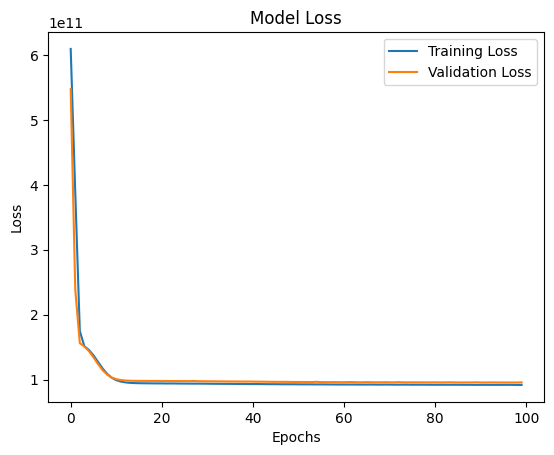

In [45]:
# Compile the model specifying optimizer and loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model using training data and validate it using test data
history = model.fit(
    x=[X1_train, X2_train],  # Input data for the model (two inputs X1_train and X2_train)
    y=y_train,  # Target data (labels)
    validation_data=([X1_test, X2_test], y_test),  # Validation data
    epochs=100,  # Number of training epochs
    batch_size=100  # Batch size for optimization
)

# Plotting the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')  # Plotting training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plotting validation loss
plt.title('Model Loss')  # Title of the plot
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Loss')  # Label for y-axis
plt.legend()  # Display legend
plt.show()  # Show the plot

# 5. Model evalvation

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predictions are already computed in previous cell
y_pred = model.predict([X1_test, X2_test])

# Calculate MAE and RMSE correctly
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Absolute Error (MAE): 224766.4907
Root Mean Squared Error (RMSE): 308974.1340
